In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    accuracy_score
)

import os   # ← THIS IS THE IMPORTANT ONE

Matplotlib is building the font cache; this may take a moment.


In [3]:
# Create the data folder if it doesn't exist
os.makedirs("../data", exist_ok=True)

np.random.seed(42)

n_rows = 10000

months = np.random.randint(1, 13, size=n_rows)
days_of_month = np.random.randint(1, 29, size=n_rows)
days_of_week = np.random.randint(1, 8, size=n_rows)

carriers = np.random.choice(["AA", "DL", "UA", "SW", "AS"], size=n_rows)
origins = np.random.choice(["JFK", "LAX", "ATL", "ORD", "DFW"], size=n_rows)
destinations = np.random.choice(["JFK", "LAX", "ATL", "ORD", "DFW"], size=n_rows)

dep_time = np.random.randint(0, 2359, size=n_rows)

# Base departure delay
dep_delay = np.random.normal(loc=5, scale=20, size=n_rows)

# Add extra delay for some carriers & busy routes
dep_delay += np.where(carriers == "AA", 5, 0)
dep_delay += np.where(origins == "JFK", 3, 0)

# Arrival delay is departure delay + some noise
arr_delay = dep_delay + np.random.normal(loc=0, scale=10, size=n_rows)

flights_df = pd.DataFrame({
    "MONTH": months,
    "DAY_OF_MONTH": days_of_month,
    "DAY_OF_WEEK": days_of_week,
    "OP_UNIQUE_CARRIER": carriers,
    "ORIGIN": origins,
    "DEST": destinations,
    "DEP_TIME": dep_time,
    "DEP_DELAY": dep_delay,
    "ARR_DELAY": arr_delay
})

csv_path = "../data/flights_sample.csv"
flights_df.to_csv(csv_path, index=False)

csv_path

'../data/flights_sample.csv'

In [4]:
df = pd.read_csv("../data/flights_sample.csv")
df.head()

,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,OP_UNIQUE_CARRIER,ORIGIN,DEST,DEP_TIME,DEP_DELAY,ARR_DELAY
0,7,23,1,SW,JFK,ATL,2307,35.542349,27.945672
1,4,9,3,SW,DFW,LAX,986,4.107089,13.006498
2,11,10,6,UA,JFK,LAX,816,10.783482,10.279932
3,8,28,1,UA,DFW,ATL,2201,10.619025,9.881176
4,5,2,2,AA,LAX,ORD,2169,51.865067,47.012119


In [5]:
df.describe(include="all").T.head(15)

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
MONTH,10000.0,NaN,NaN,NaN,6.4964,3.45699,1.0,3.0,6.0,10.0,12.0
DAY_OF_MONTH,10000.0,NaN,NaN,NaN,14.6157,8.027083,1.0,8.0,15.0,22.0,28.0
DAY_OF_WEEK,10000.0,NaN,NaN,NaN,3.9863,2.01249,1.0,2.0,4.0,6.0,7.0
OP_UNIQUE_CARRIER,10000,5,AS,2152,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ORIGIN,10000,5,ORD,2054,NaN,NaN,NaN,NaN,NaN,NaN,NaN
DEST,10000,5,LAX,2034,NaN,NaN,NaN,NaN,NaN,NaN,NaN
DEP_TIME,10000.0,NaN,NaN,NaN,1174.0241,680.988567,0.0,585.0,1173.0,1755.0,2358.0
DEP_DELAY,10000.0,NaN,NaN,NaN,6.707801,20.156743,-80.90782,-6.789935,6.676759,20.473449,75.730633
ARR_DELAY,10000.0,NaN,NaN,NaN,6.705558,22.463417,-87.27891,-8.777674,6.926614,21.76231,89.53626


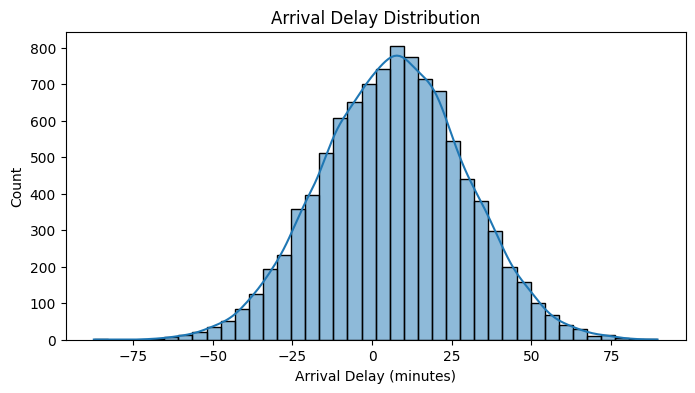

In [6]:
plt.figure(figsize=(8, 4))
sns.histplot(df["ARR_DELAY"], kde=True, bins=40)
plt.title("Arrival Delay Distribution")
plt.xlabel("Arrival Delay (minutes)")
plt.show()

In [7]:
df_clean = df.dropna().copy()

# Binary target: 1 if arrival delay > 15 mins
df_clean["delay"] = (df_clean["ARR_DELAY"] > 15).astype(int)

# Select features
features = [
    "MONTH",
    "DAY_OF_MONTH",
    "DAY_OF_WEEK",
    "DEP_TIME",
    "DEP_DELAY",
    "OP_UNIQUE_CARRIER",
    "ORIGIN",
    "DEST",
]

df_model = df_clean[features + ["delay"]].copy()

# One-hot encode categorical features
cat_cols = ["OP_UNIQUE_CARRIER", "ORIGIN", "DEST"]
df_model = pd.get_dummies(df_model, columns=cat_cols)

X = df_model.drop("delay", axis=1)
y = df_model["delay"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

X_train.shape, X_test.shape

((8000, 20), (2000, 20))

In [8]:
rf = RandomForestClassifier(
    n_estimators=150,
    max_depth=None,
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
accuracy

0.839

In [9]:
print("Accuracy:", round(accuracy, 4))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Accuracy: 0.839

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.89      0.88      1280
           1       0.79      0.75      0.77       720

    accuracy                           0.84      2000
   macro avg       0.83      0.82      0.82      2000
weighted avg       0.84      0.84      0.84      2000


Confusion Matrix:
[[1139  141]
 [ 181  539]]


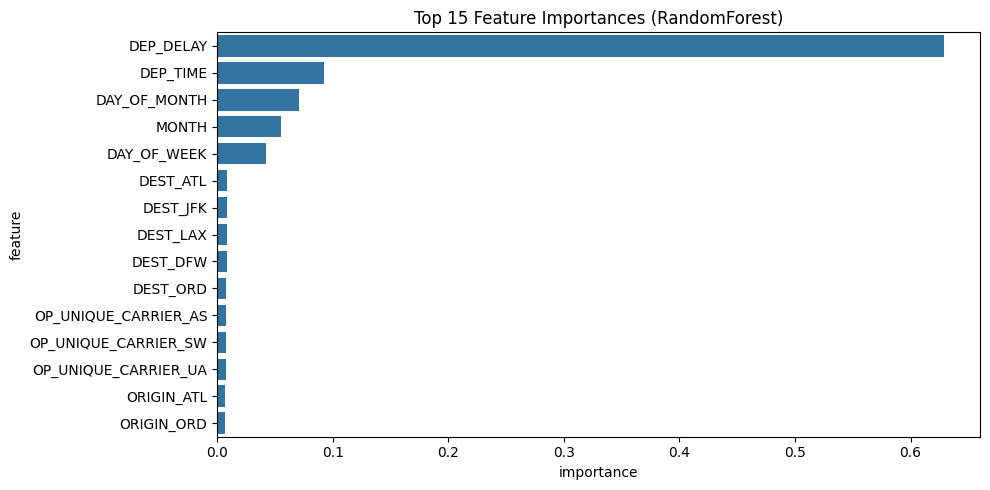

In [10]:
importances = rf.feature_importances_
features = X.columns

feat_imp = pd.DataFrame({
    "feature": features,
    "importance": importances
}).sort_values("importance", ascending=False).head(15)

plt.figure(figsize=(10, 5))
sns.barplot(data=feat_imp, x="importance", y="feature")
plt.title("Top 15 Feature Importances (RandomForest)")
plt.tight_layout()
plt.show()

In [11]:
import joblib
os.makedirs("../models", exist_ok=True)
joblib.dump(rf, "../models/flight_delay_model.pkl")

"Model saved to ../models/flight_delay_model.pkl"

'Model saved to ../models/flight_delay_model.pkl'